## COVID19 Modeling the Spread of the Coronavirus

Data on the spread of the Coronavirus that causes COVID19 are derived from the [Johns Hopkins CSSE](https://github.com/CSSEGISandData/COVID-19) via an API setup by [Kyle Redelinghuys](https://covid19api.com/).

The spread of the virus is both visualized and modeled, initially across the globe and then in individual countries such as the United States and China.


### Daily Executive Summaries
 - As of __March 14__ (with data as of March 13), about 173,000 confirmed cases are predicted to be reached by April 1st, 2020 based on a Prophet time series forecasting model with a maximal RMSE of 23,720. However, while the rate of new cases in China is flatling, the rate of new cases in the United States is increasing exponentially. This suggests that the model is predicting many fewer cases that will likely be observed as testing ramps up in the United States. 
 - As of __March 15__, a new model now predicts anout 179,000 confirmed cases to be reached by April 2nd, 2020 with a maximal RMSE of 28,500. China's new infection rate is flat. However, the United States continues to exhibit an exponential increase in the number of new cases.  
 - As of __March 16__, a model predicts that if the current rate of new confirmed cases in the US continues, that there will be 243,991 cumulative confirmed cases in the United States on April 1, 2020. This model was trained on a Log base 10 transformed cumulative number of cases in the US because the current trend is one of exponential growth. This model also predicts that by the end of today, March 16th, that there will be a total of 4,555 confirmed cases in the US. 



In [369]:
import pandas as pd
import numpy as np
from datetime import date
from datetime import datetime, timedelta
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation

In [343]:
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [344]:
# Ensure notebook takes up full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [345]:
# Supress warning messages
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

In [346]:
covid19 = pd.read_json('https://api.covid19api.com/all')
covid19.tail()

,Cases,Country,Date,Lat,Lon,Province,Status
73213,0,Uzbekistan,2020-03-11,41.3775,64.5853,,recovered
73214,0,Uzbekistan,2020-03-12,41.3775,64.5853,,recovered
73215,0,Uzbekistan,2020-03-13,41.3775,64.5853,,recovered
73216,0,Uzbekistan,2020-03-14,41.3775,64.5853,,recovered
73217,0,Uzbekistan,2020-03-15,41.3775,64.5853,,recovered


In [347]:
summed_covid19 = covid19.groupby([covid19['Status'], covid19['Date']]).sum().reset_index()

In [423]:
print('Number of cases by status of of yesterday, ' + str(date.today() - timedelta(days=1)) + " :")
summed_covid19.loc[summed_covid19['Date'] == str(date.today() - timedelta(days=1))][['Status', 'Date', 'Cases']]

Number of cases by status of of yesterday, 2020-03-15 :


,Status,Date,Cases
53,confirmed,2020-03-15,167449
107,deaths,2020-03-15,6440
161,recovered,2020-03-15,76034


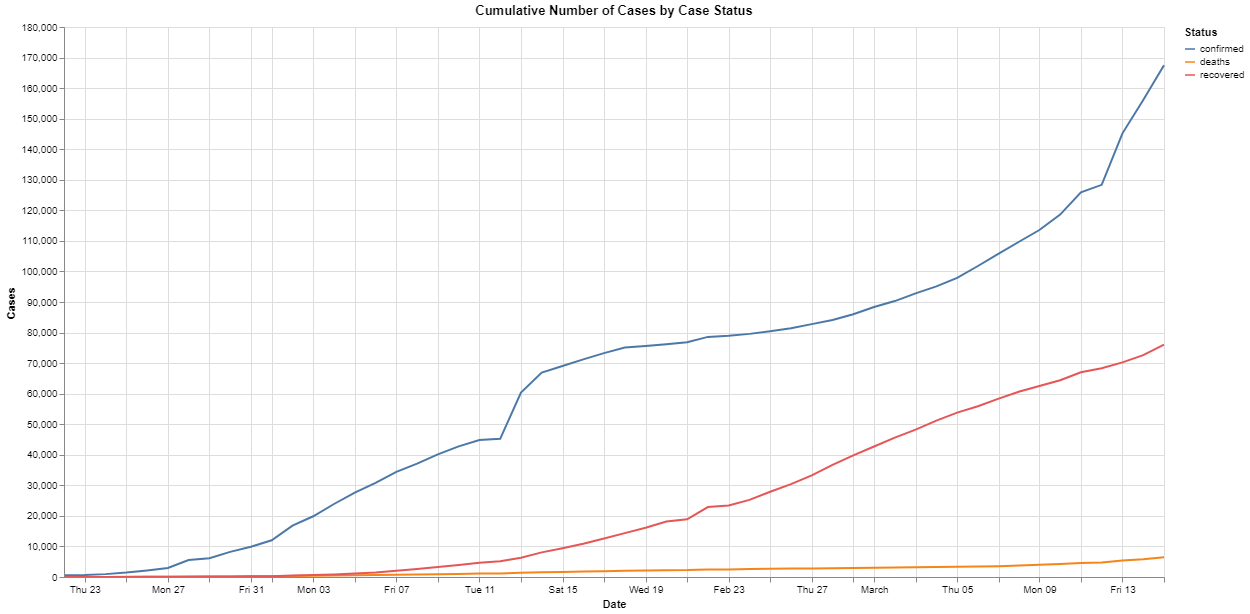

In [349]:
source = summed_covid19
alt.Chart(source).mark_line().encode(
    x='Date:T',
    y='Cases:Q',
    color='Status:N'
).properties(width=1100, height=550, title='Cumulative Number of Cases by Case Status')#.configure_axis(labelFontSize=4)

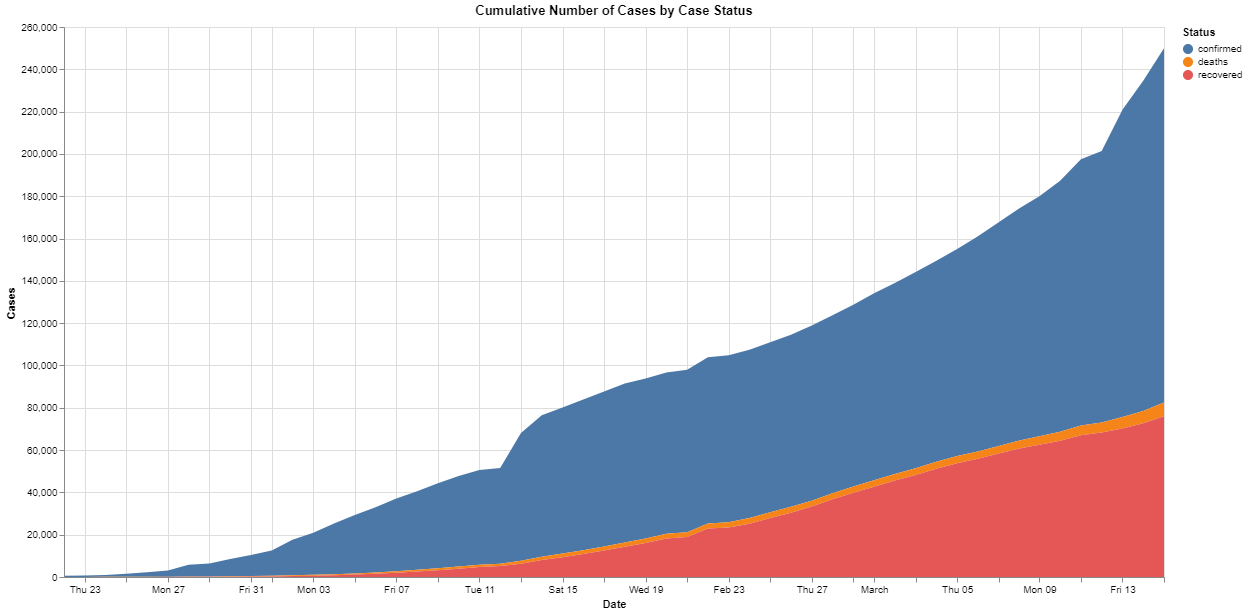

In [350]:
source = summed_covid19

alt.Chart(source).mark_area().encode(
    x='Date:T',
    y='Cases:Q',
    color='Status:N'
).properties(width=1100, height=550, title='Cumulative Number of Cases by Case Status')

In [351]:
# Data handling for prophet
summed_covid19.Date = pd.to_datetime(summed_covid19.Date)
summed_covid19['ds'] = summed_covid19.Date
summed_covid19['y'] = summed_covid19.Cases
summed_covid19.tail()

,Status,Date,Cases,Lat,Lon,ds,y
157,recovered,2020-03-11,67003,14544.9824,-16748.2710,2020-03-11,67003
158,recovered,2020-03-12,68324,14544.9824,-16748.2710,2020-03-12,68324
159,recovered,2020-03-13,70251,14544.9824,-16748.2710,2020-03-13,70251
160,recovered,2020-03-14,72624,14544.9824,-16748.2710,2020-03-14,72624
161,recovered,2020-03-15,76034,14537.0485,-16642.1452,2020-03-15,76034


In [352]:
df_m_confirmed = summed_covid19.loc[summed_covid19['Status'] == 'confirmed'][['ds', 'y']]
df_m_recovered = summed_covid19.loc[summed_covid19['Status'] == 'recovered'][['ds', 'y']]
df_m_deaths = summed_covid19.loc[summed_covid19['Status'] == 'deaths'][['ds', 'y']]

In [353]:
print('Number of days of virus monitoring: ' + str(df_m_confirmed.ds.count()))

Number of days of virus monitoring: 54


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


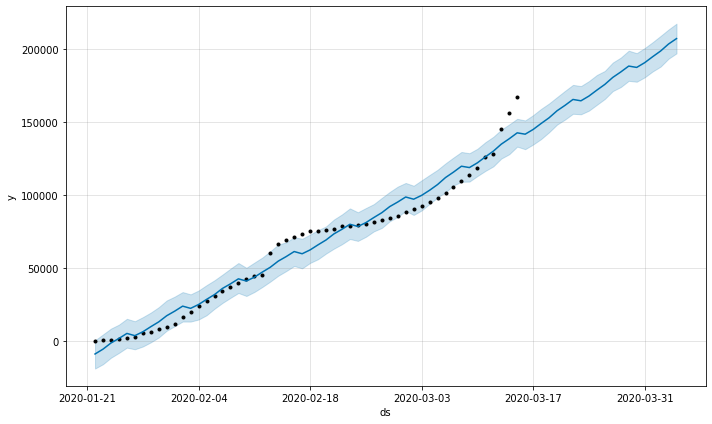

In [354]:
# Train a Prophet model to untransformed, aggregate number of cases across the globe
m_confirmed = Prophet()
m_confirmed.fit(df_m_confirmed)
future = m_confirmed.make_future_dataframe(periods=20)
forecast_confirmed = m_confirmed.predict(future)
m_confirmed.plot(forecast_confirmed);

In [412]:
forecast_confirmed[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
69,2020-03-31,190570.287285,180552.052166,200571.938416
70,2020-04-01,194650.558647,184577.547625,204580.117388
71,2020-04-02,198553.583539,187901.971637,208863.926926
72,2020-04-03,203352.127085,193325.821470,213287.067359
73,2020-04-04,207058.127820,196959.691674,217278.634149


In [356]:
df_cv = cross_validation(m_confirmed, initial='26 days', period='14 days', horizon = '5 days')
df_cv.tail(50)

INFO:fbprophet:Making 2 forecasts with cutoffs between 2020-02-25 00:00:00 and 2020-03-10 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-26,92241.604111,85628.950878,98863.820902,81395,2020-02-25
1,2020-02-27,96453.804109,89543.721838,103013.014804,82754,2020-02-25
2,2020-02-28,98993.941922,92219.981183,105916.899247,84120,2020-02-25
3,2020-02-29,100840.839444,94108.080030,107838.001963,86011,2020-02-25
4,2020-03-01,103049.723224,96302.994863,109755.335690,88369,2020-02-25
5,2020-03-11,113696.224558,107399.166629,120799.324639,125870,2020-03-10
6,2020-03-12,116878.930146,110553.621623,123921.276428,128348,2020-03-10
7,2020-03-13,119032.020466,112647.666570,125103.954921,145198,2020-03-10
8,2020-03-14,120785.438332,114295.775746,126566.010727,156107,2020-03-10
9,2020-03-15,122854.417368,116542.025951,129398.820898,167449,2020-03-10


In [357]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,coverage
0,1 days,1.329248e+08,11529.302435,11510.189777,0.114988,0.0
1,2 days,1.596121e+08,12633.768162,12584.436982,0.127454,0.0
2,3 days,4.529463e+08,21282.535484,20519.960728,0.178514,0.0
3,4 days,7.337684e+08,27088.160297,25075.700556,0.199342,0.0
4,5 days,1.102100e+09,33197.894771,29637.652928,0.216224,0.0


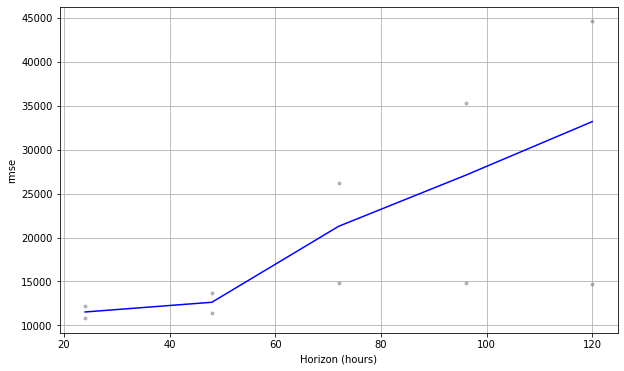

In [358]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


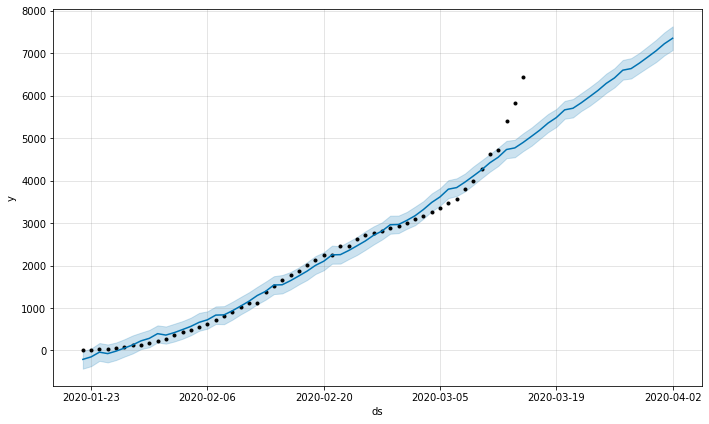

In [359]:
m_deaths = Prophet()
m_deaths.fit(df_m_deaths)
future = m_deaths.make_future_dataframe(periods=20)
forecast_deaths = m_deaths.predict(future)
m_deaths.plot(forecast);

In [360]:
forecast_deaths.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
69,2020-03-31,7962.010021,7564.052778,8282.234242,7820.359903,8118.533187,-53.683255,-53.683255,-53.683255,-53.683255,-53.683255,-53.683255,0.0,0.0,0.0,7908.326766
70,2020-04-01,8126.244454,7749.175958,8481.079989,7967.375371,8298.792355,-12.975832,-12.975832,-12.975832,-12.975832,-12.975832,-12.975832,0.0,0.0,0.0,8113.268622
71,2020-04-02,8290.478887,7916.747609,8644.575091,8115.861080,8477.931949,-26.022799,-26.022799,-26.022799,-26.022799,-26.022799,-26.022799,0.0,0.0,0.0,8264.456088
72,2020-04-03,8454.713320,8088.049971,8836.133406,8261.623395,8657.738862,12.800686,12.800686,12.800686,12.800686,12.800686,12.800686,0.0,0.0,0.0,8467.514006
73,2020-04-04,8618.947753,8292.185895,9047.063054,8410.295081,8839.022919,43.622533,43.622533,43.622533,43.622533,43.622533,43.622533,0.0,0.0,0.0,8662.570286


In [361]:
summed_covid19_by_country = covid19.groupby([covid19['Status'], covid19['Country'], covid19['Date']]).sum().reset_index()
summed_covid19_by_country.head()

,Status,Country,Date,Cases,Lat,Lon
0,confirmed,Afghanistan,2020-01-22,0,33.0,65.0
1,confirmed,Afghanistan,2020-01-23,0,33.0,65.0
2,confirmed,Afghanistan,2020-01-24,0,33.0,65.0
3,confirmed,Afghanistan,2020-01-25,0,33.0,65.0
4,confirmed,Afghanistan,2020-01-26,0,33.0,65.0


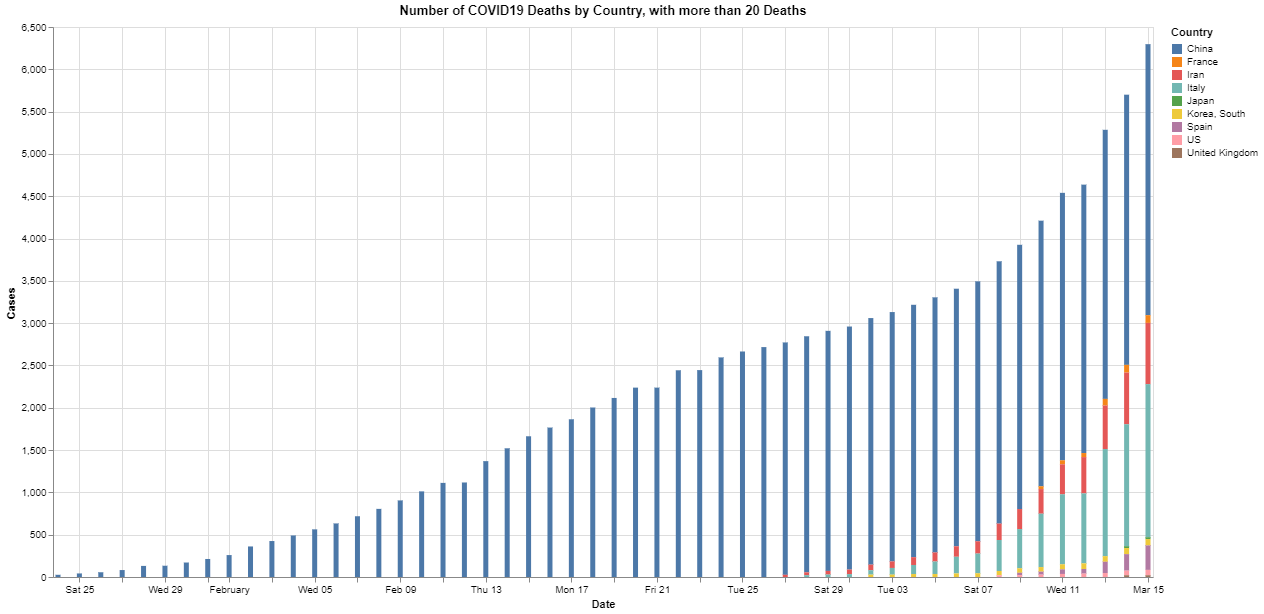

In [362]:
source = summed_covid19_by_country.loc[(summed_covid19_by_country['Status'] == 'deaths') & (summed_covid19_by_country['Cases'] > 20)]

alt.Chart(source).mark_bar().encode(
    x='Date',
    y='Cases',
    color='Country'
).properties(width=1100, height=550, title='Number of COVID19 Deaths by Country, with more than 20 Deaths')

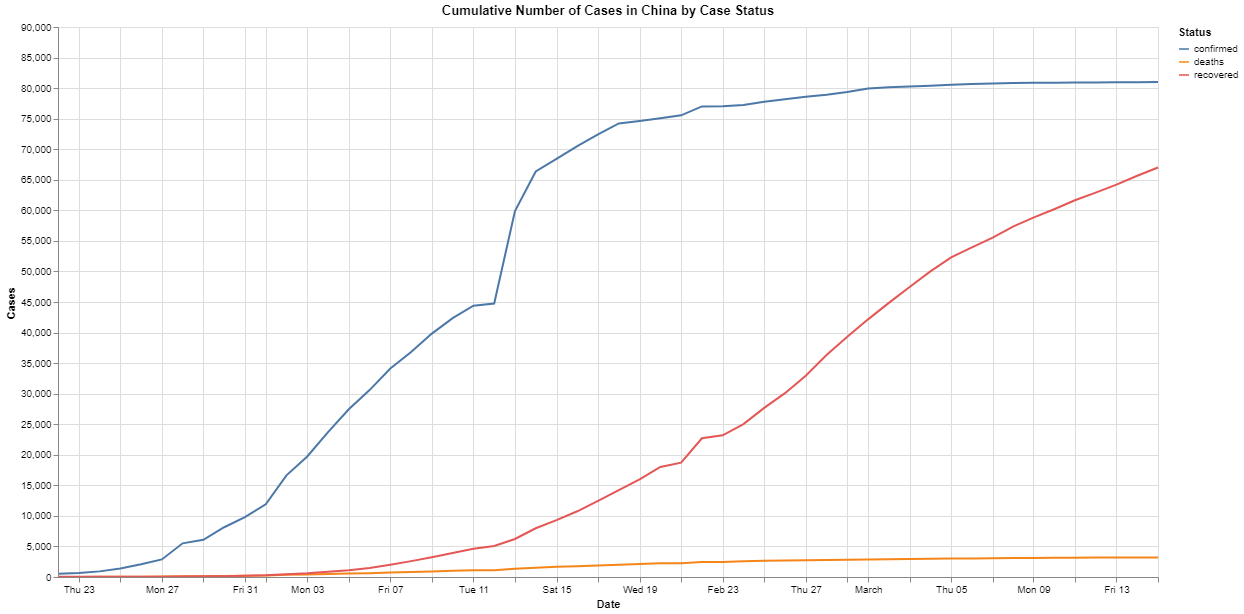

In [363]:
source = summed_covid19_by_country.loc[summed_covid19_by_country['Country'] == 'China']
alt.Chart(source).mark_line().encode(
    x='Date:T',
    y='Cases:Q',
    color='Status:N'
).properties(width=1100, height=550, title='Cumulative Number of Cases in China by Case Status')

In [364]:
# Data handling for prophet
summed_covid19_by_country.Date = pd.to_datetime(summed_covid19_by_country.Date)
summed_covid19_by_country['ds'] = summed_covid19_by_country.Date
summed_covid19_by_country['y'] = summed_covid19_by_country.Cases

df_m_confirmed_china = summed_covid19_by_country.loc[(summed_covid19_by_country['Status'] == 'confirmed') & (summed_covid19_by_country['Country'] == 'China')][['ds', 'y']]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


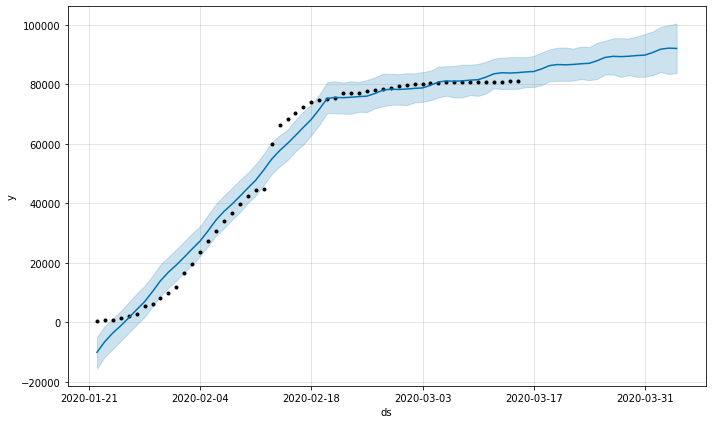

In [365]:
# Prophet forecast for China
m_confirmed_china = Prophet()
m_confirmed_china.fit(df_m_confirmed_china)
future = m_confirmed_china.make_future_dataframe(periods=20)
forecast_confirmed_china = m_confirmed_china.predict(future)
m_confirmed_china.plot(forecast_confirmed_china);

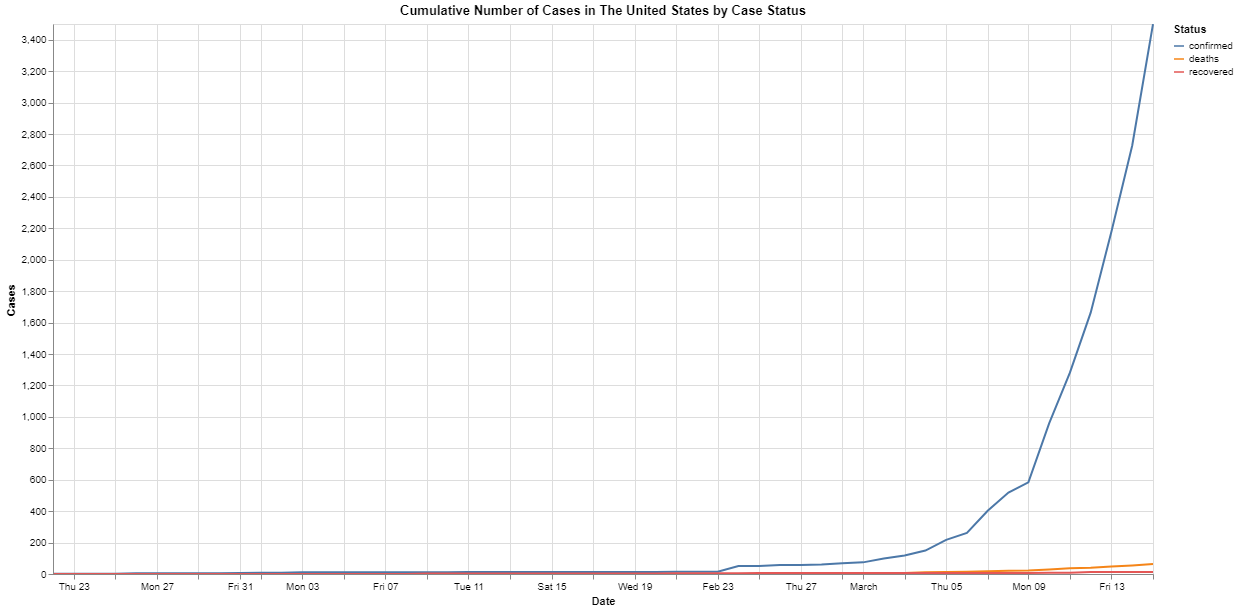

In [366]:
source = summed_covid19_by_country.loc[summed_covid19_by_country['Country'] == 'US']
alt.Chart(source).mark_line().encode(
    x='Date:T',
    y='Cases:Q',
    color='Status:N'
).properties(width=1100, height=550, title='Cumulative Number of Cases in The United States by Case Status')#.configure_axis(labelFontSize=4)

In [403]:
df_confirmed_us = summed_covid19_by_country.loc[(summed_covid19_by_country['Status'] == 'confirmed') & (summed_covid19_by_country['Country'] == 'US')][['ds', 'y']]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


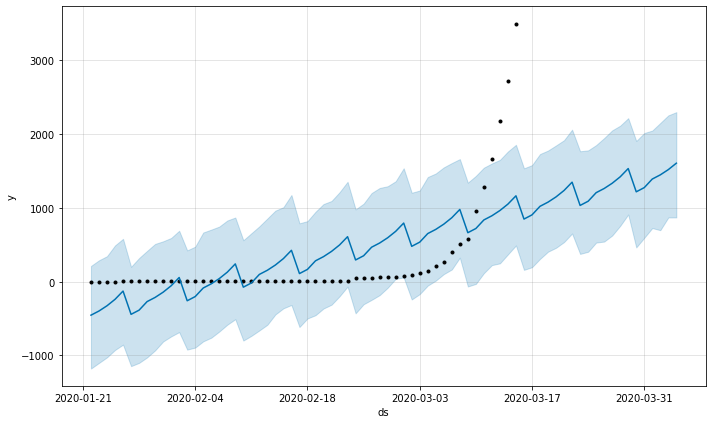

In [374]:
# Prophet forecast for the US
m_confirmed_us = Prophet()
m_confirmed_us.fit(df_confirmed_us)
future = m_confirmed_us.make_future_dataframe(periods=20)
forecast_confirmed_us = m_confirmed_us.predict(future)
m_confirmed_us.plot(forecast_confirmed_us);

This is obviously fitting terribly due to the exponential growth trend. In order to fit a linear model to an exponential trend, we need to transform the data - log 10 is a good place to start.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


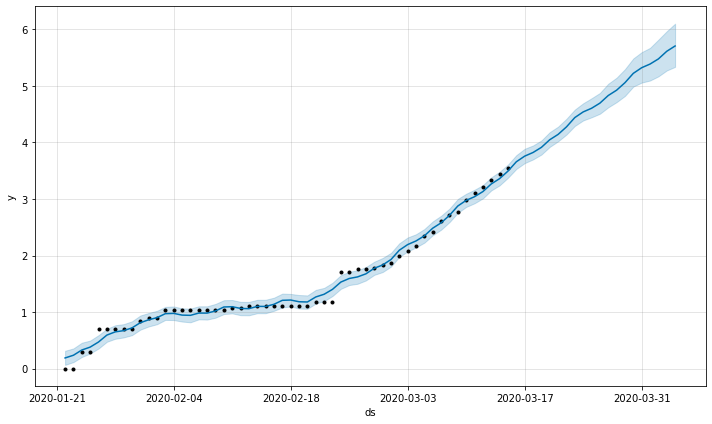

In [404]:
# Log transform the number of confirmed US cases
#… logging converts multiplicative relationships to additive relationships, and by the same token it converts exponential (compound growth) trends to linear trends. 
# By taking logarithms of variables which are multiplicatively related and/or growing exponentially over time, we can often explain their behavior with linear models.
df_confirmed_us_log = df_confirmed_us.copy(deep=True) 
df_confirmed_us_log['y'] = np.log10(df_confirmed_us_log['y'])

# Prophet forecast for the US
m_confirmed_us_log = Prophet()
m_confirmed_us_log.fit(df_confirmed_us_log)
future = m_confirmed_us_log.make_future_dataframe(periods=20)
forecast_confirmed_us_log = m_confirmed_us_log.predict(future)
m_confirmed_us_log.plot(forecast_confirmed_us_log);

In [411]:
print("Model's predicted number of confirmed US cases on " + str(date.today()) + ": " \
      + str(round(10 ** forecast_confirmed_us_log.loc[forecast_confirmed_us_log['ds'] == str(date.today())]['yhat'].item())))

Model's predicted number of confirmed US cases on 2020-03-16: 4555


In [410]:
print("Model's predicted number of confirmed US cases on " + '2020-04-01' + ": " \
      + str(round(10 ** forecast_confirmed_us_log.loc[forecast_confirmed_us_log['ds'] == '2020-04-01']['yhat'].item())))

Model's predicted number of confirmed US cases on 2020-04-01: 243991


In [414]:
df_cv_log_us = cross_validation(m_confirmed_us_log, initial='26 days', period='14 days', horizon = '5 days')
df_cv_log_us.tail(15)

INFO:fbprophet:Making 2 forecasts with cutoffs between 2020-02-25 00:00:00 and 2020-03-10 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-26,1.410708,1.200094,1.623482,1.755875,2020-02-25
1,2020-02-27,1.417606,1.202768,1.629599,1.763428,2020-02-25
2,2020-02-28,1.519390,1.309932,1.737865,1.778151,2020-02-25
3,2020-02-29,1.530943,1.319475,1.730341,1.832509,2020-02-25
4,2020-03-01,1.610465,1.405313,1.820757,1.869232,2020-02-25
5,2020-03-11,2.680954,2.476929,2.882185,3.107549,2020-03-10
6,2020-03-12,2.738391,2.512614,2.948608,3.220892,2020-03-10
7,2020-03-13,2.853002,2.649416,3.066674,3.338257,2020-03-10
8,2020-03-14,2.918085,2.709420,3.108980,3.435685,2020-03-10
9,2020-03-15,3.018380,2.811876,3.236184,3.543944,2020-03-10


In [417]:
df_p_log_us = performance_metrics(df_cv_log_us)
df_p_log_us

,horizon,mse,rmse,mae,mape,coverage
0,1 days,0.150562,0.388023,0.385881,0.166928,0.0
1,2 days,0.176200,0.419762,0.414162,0.172956,0.0
2,3 days,0.151215,0.388864,0.372008,0.145442,0.0
3,4 days,0.179426,0.423587,0.409583,0.157609,0.0
4,5 days,0.171589,0.414232,0.392165,0.143367,0.0


In [420]:
10 ** df_p_log_us[['mse', 'rmse', 'mae', 'mape']]

,mse,rmse,mae,mape
0,1.414366,2.443560,2.431538,1.468682
1,1.500376,2.628828,2.595145,1.489209
2,1.416495,2.448295,2.355094,1.397791
3,1.511563,2.652085,2.567932,1.437505
4,1.484529,2.595568,2.466977,1.391127
